# **ENTREGABLE MASTER BIG DATA SCIENCE**

CURSO. ANÁLISIS ESTADÍSTICO DE DATOS

ALUMNO. JOSE MARROQUÍN RODRÍGUEZ

BASE DE DATOS ESCOGIDA. fordpriceprediction.csv

OBJETIVO. EL OBJETIVO DEL TRABAJO ES CONSTRUIR UN MODELO DE REGRESIÓN LINEAL PARA HACER PREDICCIONES

## PARTE I

Escribir el modelo resultante de la regresión lineal sin regularización y los modelos obtenidos con las regresiones con regularización de Ridge y Lasso considerando todas las variables predictoras del problema. Comparar los modelos e interpretarlos a partir de las métricas y las técnicas validación gráfica.

###PREPARACIÓN DE DATOS

Variables categóricas: ['model', 'transmission', 'fueltype']


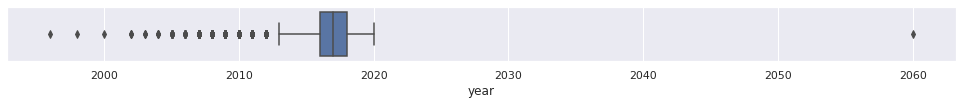

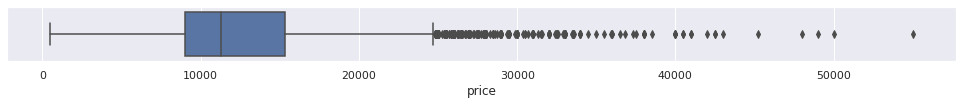

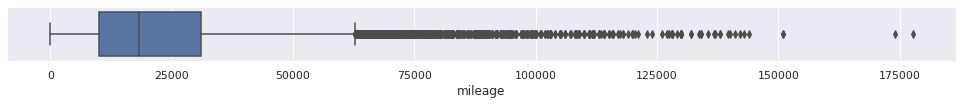

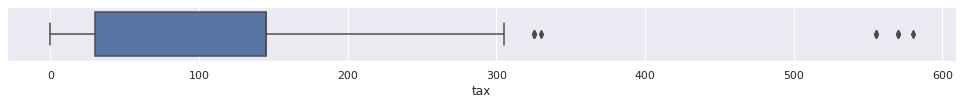

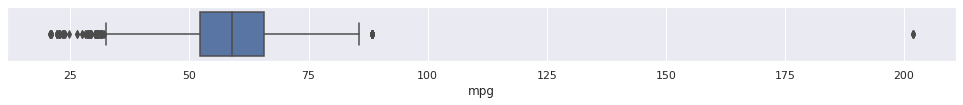

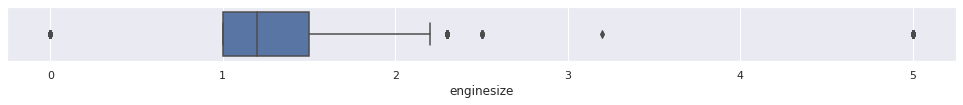

In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
sns.set()

#LECTURA DEL ARCHIVO DESDE UN REPOSITORIO DÓNDE SUBIMOS LA DATA
url="https://archivos.abcmovil.pe/fordpriceprediction.csv"
df=pd.read_csv(url)


#SACAMOS UNA COPIA PARA LA PARTE V
df_original = df.copy()


df.columns = map(str.lower, df.columns) #convertimos las variables a minúsculas
#display(df.columns)
#print(df.info())


#MOSTRAMOS LAS VARIABLES CATEGORICAS
catCols = [col for col in df.columns if df[col].dtype=="object"]
print("Variables categóricas:", catCols)

#PROCESAMIENTO DE LAS VARIABLES CATEGORICAS
#POSIBILIDADES : LABEL ENCODER -  ORDINAL ENCODER - ONE HOT ENCODER.
#DECIDIMOS UTILIZAR ONE LABEL ENCODER EN EL CASO EN EL QUÉ EXISTEN MUCHAS VARIABLES Y EN LOS OTROS CASOS UTILIZAMOS ONE HOT ENCODER.

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['model'] = label_encoder.fit_transform(df['model'])
#print(df.info())

from sklearn.preprocessing import OneHotEncoder
codificador = OneHotEncoder()
codificacion = codificador.fit_transform(df[["transmission"]])
nuevas_cols = pd.DataFrame(codificacion.toarray(),columns=codificador.categories_)
df = pd.concat([df, nuevas_cols], axis="columns")
df.rename(columns={df.columns[9]: 'automatic',
                   df.columns[10]: 'manual' , 
                   df.columns[11]: 'semi_automatic'
                   }, inplace=True)

codificador = OneHotEncoder()
codificacion = codificador.fit_transform(df[["fueltype"]])
nuevas_cols = pd.DataFrame(codificacion.toarray(),columns=codificador.categories_)
df = pd.concat([df, nuevas_cols], axis="columns")
df.rename(columns={df.columns[12]: 'diesel',
                   df.columns[13]: 'electric', 
                   df.columns[14]: 'hybrid',
                   df.columns[15]: 'other',
                   df.columns[16]: 'petrol'
                   }, inplace=True)
df.drop([ 'transmission'] , axis="columns",inplace=True)
df.drop([ 'fueltype'] , axis="columns",inplace=True)


#HACEMOS QUE LAS VARIABLES CATEGÓRICAS NO PASEN POR EL ELIMINADOR DE OUTLIERS
df['model'] = df['model'].astype(object)
df['automatic'] = df['automatic'].astype(object)
df['manual'] = df['manual'].astype(object)
df['semi_automatic'] = df['semi_automatic'].astype(object)
df['diesel'] = df['diesel'].astype(object)
df['electric'] = df['electric'].astype(object)
df['hybrid'] = df['hybrid'].astype(object)
df['other'] = df['other'].astype(object)
df['petrol'] = df['petrol'].astype(object)



#VERIFICAMOS NULL
#print(df.isnull().sum())


#VERIFICAMOS LA DATA:
i = 0 
for column in df:
  if df[column].dtype != 'object':
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df, x=column)





ELIMINAMOS OUTLIERS

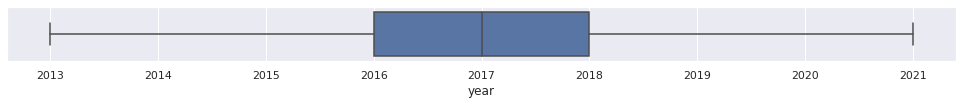

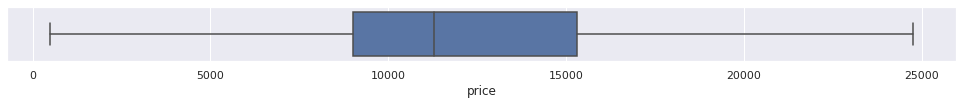

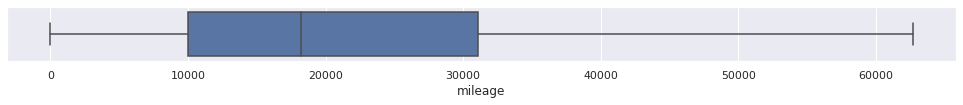

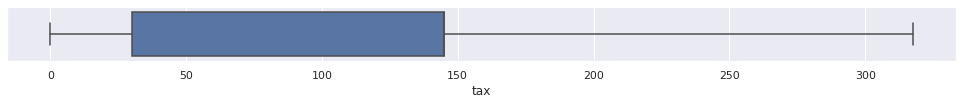

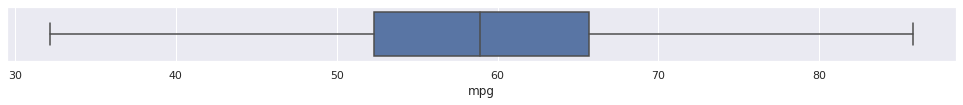

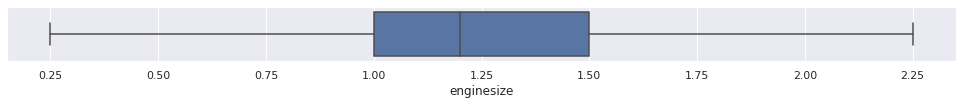

In [2]:
#ELIMINAMOS LOS OUTLIERS 
def eliminar_outlier(col): 
   sorted(col)
   Q1,Q3=np.percentile(col,[25,75])
   IQR=Q3-Q1
   lowerthr= Q1-(1.5 * IQR) #UMBRAL INFERIOR
   upperthr= Q3+(1.5 * IQR) #UMBRAL SUPERIOR
   return lowerthr,upperthr


for column in df.columns: #aplicamos la función eliminar_outlier para cada variable (columna) del dataframe QUE NO SEA CATEGORICA
    if df[column].dtype != 'object': 
        lowerthr,upperthr=eliminar_outlier(df[column])
        df[column]=np.where(df[column]>upperthr,upperthr,df[column])
        df[column]=np.where(df[column]<lowerthr,lowerthr,df[column])


#COMRPOBAMOS QUE SE HAYA EJECUTADO CORRECTAMENTE SOBRE LAS VARIABLES NO CATEGORICAS.
for column in df:
  if df[column].dtype != 'object':
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df, x=column)

In [3]:
#REALIZAMOS LA ESTANDARIZACIÓN
dfestand=df.copy()
#print(dfestand.columns)


from sklearn.preprocessing import StandardScaler #importamos la librería para estandarizar
scalerX = StandardScaler()
lista_columnas=['model', 'year', 'price', 'mileage', 'tax', 'mpg', 'enginesize','automatic', 'manual', 'semi_automatic', 'diesel', 'electric', 'hybrid','other', 'petrol']
dfestand[lista_columnas] = scalerX.fit_transform(dfestand[lista_columnas])

scalerY = StandardScaler()
dfestand['price']=scalerY.fit_transform(np.array(dfestand['price']).reshape(len(dfestand['price']),1)).reshape(len(dfestand['price']))



###CONDICIONES DE NORMALIDAD

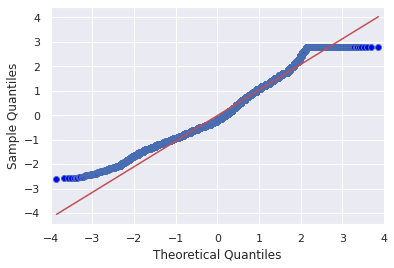

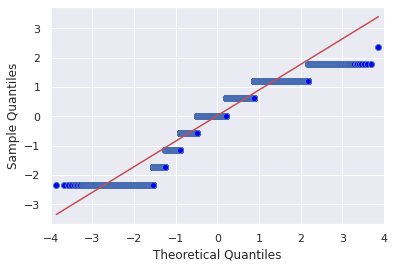

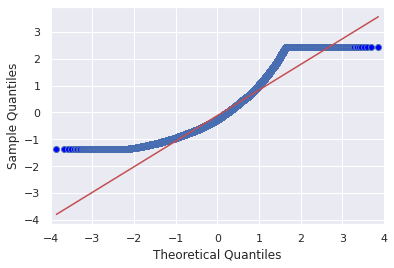

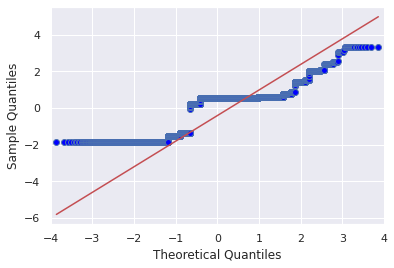

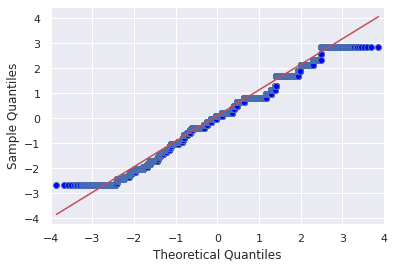

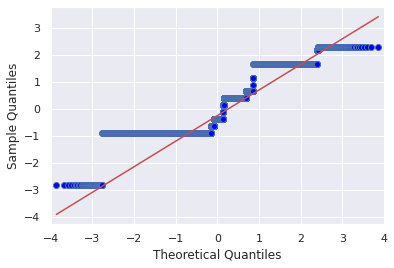

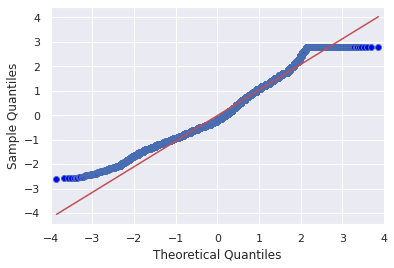

In [4]:
sm.qqplot(dfestand['year'], line='q')
sm.qqplot(dfestand['mileage'], line='q')
sm.qqplot(dfestand['tax'], line='q')
sm.qqplot(dfestand['mpg'], line='q')
sm.qqplot(dfestand['enginesize'], line='q')
sm.qqplot(dfestand['price'], line='q')

### LINEAR REGRESSION

APLICAMOS UNA SEPARACIÓN DE 70% Y 30% PARA EL ENTRENAMIENTO Y EL TESTEO RESPECTIVAMENTE

In [5]:
X = dfestand.drop(['price'],axis=1).values
Y = dfestand['price'].values

from sklearn.model_selection import train_test_split #importamos la función para construir las muestras de entrenamiento y de test.
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=3,test_size=0.3)


from sklearn.linear_model import LinearRegression #Importamos la función regresión lineal
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error #Importamos la función MSE
#Obtención del modelo de regresión lineal para la muestra de entrenamiento
lr= LinearRegression() 
lr.fit(X_train, Y_train) #construcción del modelo a partir de los datos de entrenamiento.
#Cálculo de los valores predichos a partir de la muestra de entrenamiento
Y_train_pred= lr.predict(X_train)
#Cálculo de los valores predichos a partir de la muestra de test
Y_test_pred= lr.predict(X_test)
#GUARDAMOS LOS PARÁMETROS
parametroslr=lr.coef_





####EVALUACIÓN DE MÉTRICAS

VERIFICAMOS QUE EXISTE UNA CERCANÍA ENTRE LA MÉTRICA R2 TANTO PARA EL TRAIN CÓMO PARA LA PREDICCIÓN SOBRE EL TEST, POR TANTO DECIMOS QUE NO EXISTE SOBREAJUSTE SOBRE EL ENTRENAMIENTO

In [6]:
#EVALUACIÓN DE MÉTRICAS
def calculametricas(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred) #Error absoluto medio (MAE)
    mse = metrics.mean_squared_error(y_test, y_pred) #Error cuadrático medio (MSE)
    rmse = math.sqrt(mse) #Error estándar de la estimación (RMSE)
    r2 = metrics.r2_score(y_test, y_pred) #Cálculo del coeficiente de determinación R2
    #print("MAE : ",mae)
    #print("MSE : ",mse)
    #print("RMSE : ",rmse)
    #print("R2 : ",r2)
    return mae,mse,rmse,r2


metricasLR_train=calculametricas(Y_train, Y_train_pred)
metricasLR_test=calculametricas(Y_test, Y_test_pred)

dfmetricasLR_train=pd.DataFrame(metricasLR_train).rename(columns = {0:'train'})
dfmetricasLR_test=pd.DataFrame(metricasLR_test).rename(columns = {0:'test'})
dfmetricasLR_traintest=pd.concat([dfmetricasLR_train,dfmetricasLR_test], axis=1, ignore_index=True)
dfmetricasLR_traintest = dfmetricasLR_traintest.rename(columns = {0:'train',1:'test'},index={0: 'MAE',1:'MSE',2:'RMSE',3:'R2'})
dfmetricasLR_traintest



,train,test
MAE,0.372093,0.366880
MSE,0.238402,0.233660
RMSE,0.488264,0.483384
R2,0.763989,0.760666


####VISUALIZACIÓN Y ANÁLISIS
ESPERAMOS QUE EN LA VISUALIZACIÓN SE PROYECTE UNA LÍNEA INCLINADA 

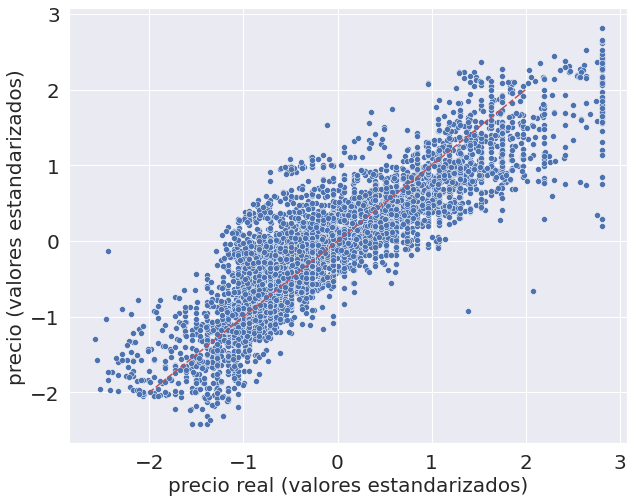

In [7]:
sY_test = pd.Series(Y_test)
sY_test.name = 'Y_test'

sY_test_pred= pd.Series(Y_test_pred)
sY_test_pred.name = 'Y_test_pred'

dfYs = pd.concat([sY_test, sY_test_pred], axis=1)
dfYs.head()

plt.figure(figsize=(10,8))
sns.scatterplot(data=dfYs, x="Y_test", y="Y_test_pred",color="b")
#--------------------código para el diseño del gráfico---------------------------------
plt.xlabel('precio real (valores estandarizados)', fontsize='20')
plt.ylabel('precio (valores estandarizados)', fontsize='20')
plt.plot([-2,2],[-2,2],'--r')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


Diagrama de dispersión de los valores predichos frente a los valores reales (en las unidades de origen)



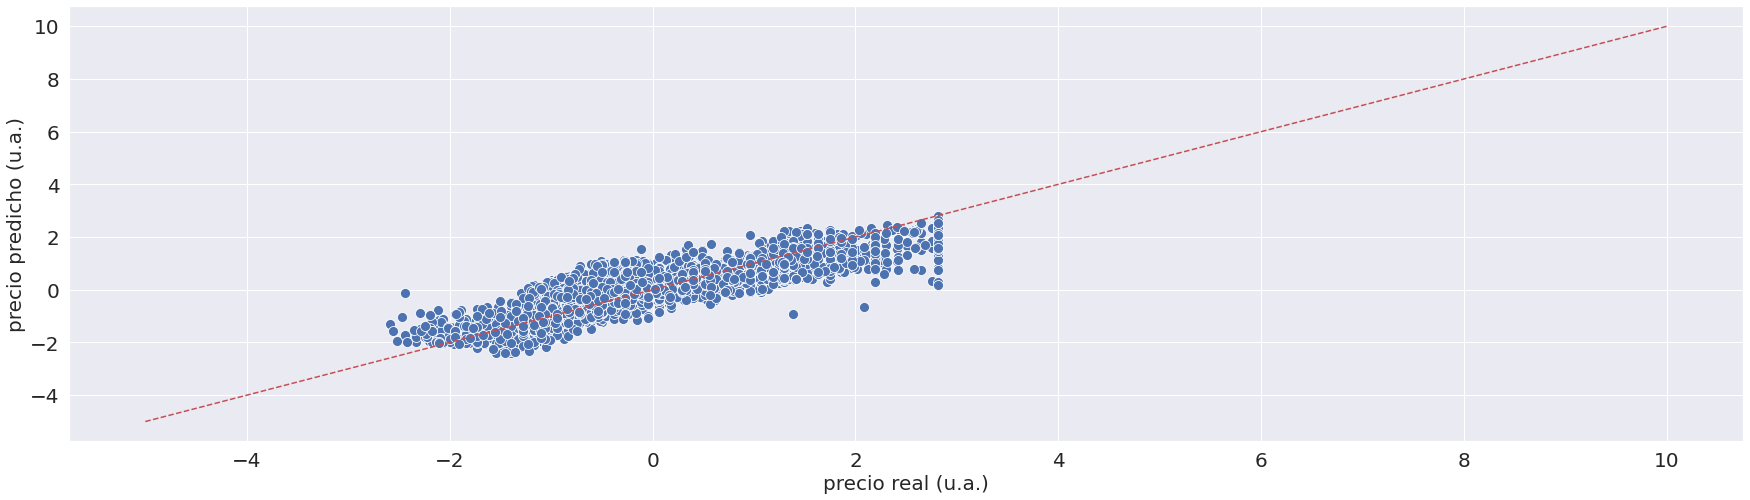

In [8]:
Y_test_pred2D= Y_test_pred.reshape(-1,1) # debemos hacer esta transformación de un array 1D a uno 2D para poder ejecutar inverse_tranform

Y_test_pred_inv = scalerY.inverse_transform(Y_test_pred2D)

Y_test2D= Y_test.reshape(-1,1) # debemos hacer esta transformación de un array 1D a uno 2D para poder ejecutar inverse_tranform

Y_test_inv = scalerY.inverse_transform(Y_test2D)
#Y_test_inv[:,0].shape

sY_test_inv = pd.Series(Y_test_inv[:,0]) #con Y_test_inv[:,0] convertimos el array 2D en 1D
sY_test_inv.name = 'Y_test_inv'

sY_test_pred_inv= pd.Series(Y_test_pred_inv[:,0])
sY_test_pred_inv.name = 'Y_test_pred_inv'

dfYinv = pd.concat([sY_test_inv, sY_test_pred_inv], axis=1)

dfYinv.head()

plt.figure(figsize=(30,8))
sns.scatterplot(data=dfYinv, x="Y_test_inv", y="Y_test_pred_inv",color="b",s=100)
#--------------------código para el diseño del gráfico---------------------------------
plt.xlabel('precio real (u.a.)', fontsize='20')
plt.ylabel('precio predicho (u.a.)', fontsize='20')
plt.plot([-5,10],[-5,10],'--r')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Histograma y curva de densidad de los residuos

PARA EL GRÁFICO DE LOS RESIDUOS AL TRATARSE DE UNA REGRESIÓN LINEAL , ESPERAMOS UNA DISTRIBUCIÓN GAUSSIANA.

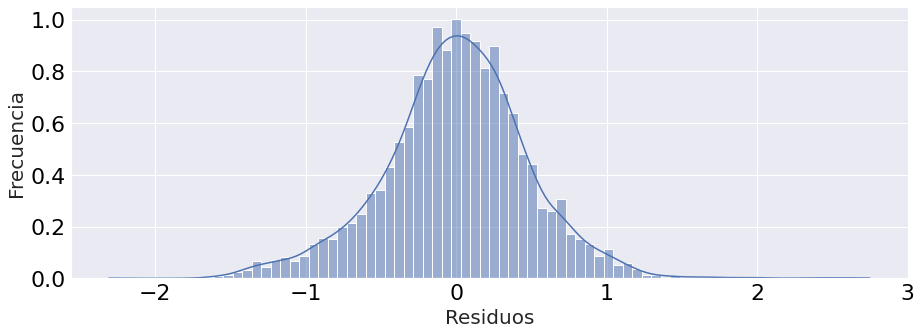

In [9]:
Residuos = Y_test-Y_test_pred
sResiduos = pd.Series(Residuos)
sResiduos.name = 'Residuos'

plt.figure('', figsize = (15,5))
g=sns.histplot(sResiduos, stat='density',kde=True)
#--------------------código para el diseño del gráfico---------------------------------
plt.xlabel('Residuos',size = 20)
plt.ylabel('Frecuencia',size = 20)
g.tick_params(axis='x', length=2,labelsize=22,labelcolor="black")
g.tick_params(axis='y', length=2,labelsize=22,labelcolor="black")



###RIDGE REGULARIZACIÓN


In [10]:
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=1, solver = 'auto', random_state = 9) #Si selecionamos alpha = 0 se correspondería con una regresión lineal sin penalización
ridge=ridge_regression.fit(X_train, Y_train)
print("Los parámetros de la regresión de Ridge son\n", ridge.coef_) #Comprobamos el peso que se asigna a las distintas variables predictoras
Y_train_pred_ridge = ridge_regression.predict(X_train)
Y_test_pred_ridge = ridge_regression.predict(X_test)
###############Cálculo de las métricas#######################
print("Métricas calculadas sobre la muestra de entrenamiento")
metricasRidge_train=calculametricas(Y_train, Y_train_pred_ridge)
print("Métricas calculadas sobre la muestra de test")
metricasRidge_test=calculametricas(Y_test, Y_test_pred_ridge)

Los parámetros de la regresión de Ridge son
 [ 0.03086384  0.59196992 -0.23263278 -0.07711839 -0.23519873  0.33726399
  0.02536347 -0.03080225  0.01617245  0.06864086  0.00311013  0.01858597
  0.00182513 -0.07005305]
Métricas calculadas sobre la muestra de entrenamiento
Métricas calculadas sobre la muestra de test


###LASSO REGULARIZACIÓN

In [11]:
from sklearn.linear_model import Lasso
lasso_regression = Lasso(alpha=0.01, random_state = 8) 
lasso=lasso_regression.fit(X_train, Y_train)
print("Los parámetros de la regresión de Lasso son\n", lasso.coef_) #Comprobamos el peso que se asigna a las distintas variables predictoras
Y_train_pred_lasso = lasso_regression.predict(X_train)
Y_test_pred_lasso = lasso_regression.predict(X_test)
###############Cálculo de las métricas#######################
print("Métricas calculadas sobre la muestra de entrenamiento")
metricasLasso_train=calculametricas(Y_train, Y_train_pred_lasso)
print("Métricas calculadas sobre la muestra de test")
metricasLasso_test=calculametricas(Y_test, Y_test_pred_lasso)

Los parámetros de la regresión de Lasso son
 [ 0.02877677  0.57591866 -0.22491413 -0.04456518 -0.20459417  0.34257033
  0.00234859 -0.05475233  0.          0.          0.          0.00534436
  0.         -0.1175083 ]
Métricas calculadas sobre la muestra de entrenamiento
Métricas calculadas sobre la muestra de test


###COMPARACIÓN DE LOS RESULTADOS

In [12]:
dfmetricasLR_test=pd.DataFrame(metricasLR_test)
dfmetricasRidge_test=pd.DataFrame(metricasRidge_test)
dfmetricasLasso_test=pd.DataFrame(metricasLasso_test)
dfmetricasLRRL_test=pd.concat([dfmetricasLR_test, dfmetricasRidge_test, dfmetricasLasso_test],axis=1,ignore_index=True)
dfmetricasLRRL_test = dfmetricasLRRL_test.rename(columns = {0:'LR',1:'Ridge',2:'Lasso'},index={0: 'MAE',1:'MSE',2:'RMSE',3:'R2'})
dfmetricasLRRL_test

,LR,Ridge,Lasso
MAE,0.366880,0.366165,0.367075
MSE,0.233660,0.233424,0.234224
RMSE,0.483384,0.483140,0.483966
R2,0.760666,0.760908,0.760089


###COMPARACIÓN DE LOS PARÁMETROS

VAMOS A OBSERVAR LA DIFERENCIA ENTRE LOS PARÁMETROS DE LA REGRESIÓN LINEAL VS RIDGE Y LASSO

In [13]:
dflrcoef=pd.DataFrame(parametroslr)
dfridgecoef=pd.DataFrame(ridge.coef_)
dflassocoef=pd.DataFrame(lasso.coef_)
dflrcoef=dflrcoef.rename(columns = {0:'Parámetro_lr'})
dfridgecoef=dfridgecoef.rename(columns = {0:'Parámetro_ridge'})
dflassocoef=dflassocoef.rename(columns = {0:'Parámetro_lasso'})
dfcoeficientes=dflrcoef.join(dflassocoef).join(dfridgecoef)
dfcoeficientes= dfcoeficientes.rename_axis('Variable').reset_index()
print(dfcoeficientes)

    Variable  Parámetro_lr  Parámetro_lasso  Parámetro_ridge
0          0  2.121911e-02         0.028777         0.030864
1          1  5.867678e-01         0.575919         0.591970
2          2 -2.333523e-01        -0.224914        -0.232633
3          3 -7.811168e-02        -0.044565        -0.077118
4          4 -2.370486e-01        -0.204594        -0.235199
5          5  3.344735e-01         0.342570         0.337264
6          6 -5.695791e+12         0.002349         0.025363
7          7 -7.384636e+12        -0.054752        -0.030802
8          8 -5.132083e+12         0.000000         0.016172
9          9  7.344664e+12         0.000000         0.068641
10        10  1.660163e+11         0.000000         0.003110
11        11  5.503072e+11         0.005344         0.018586
12        12  1.173945e+11         0.000000         0.001825
13        13  7.353037e+12        -0.117508        -0.070053


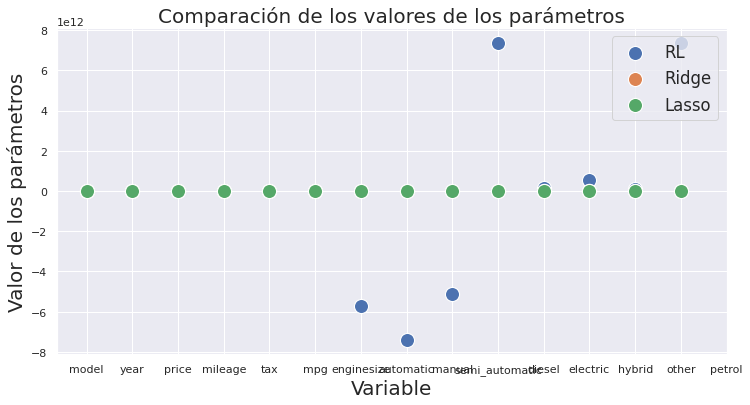

In [14]:
fig, ax = plt.subplots(figsize = (12 , 6))
sns.set(font_scale=1.5)
sns.scatterplot(data=dfcoeficientes, x='Variable', y='Parámetro_lr',legend='full',palette='bright',s=200)
sns.scatterplot(data=dfcoeficientes, x='Variable', y='Parámetro_lasso',legend='full',palette='bright',s=200)
sns.scatterplot(data=dfcoeficientes, x='Variable', y='Parámetro_ridge',legend='full',palette='bright',s=200)
ax.set_title( "Comparación de los valores de los parámetros" , size = 20)
ax.set_xlabel('Variable',size=20)
ax.set_ylabel('Valor de los parámetros',size=20)
ax.legend(loc='upper right', labels=['RL', 'Ridge','Lasso'])
ax.set_xticks(range(len(lista_columnas)))
ax.set_xticklabels(lista_columnas)
plt.show()

##PARTE II

Ensayar otros valores de k o n_features_to_select en los siguientes métodos supervisados de selección de variables:

*   SelectKBest (r_regresion y f_regression).
*   Selección secuencial, SFS (backward y forward).
*   Eliminación recursiva, RFE y RFECV.


###SELECTKBEST (R_REGRESION).
SELECCIONAREMOS LAS 4 MEJORES VARIABLES

In [15]:
from sklearn.feature_selection import r_regression, SelectKBest
rselect = SelectKBest(r_regression, k=4)
rselect.fit_transform(X, Y)
rfilter = rselect.get_support(indices=True)

dflista_columnas=pd.DataFrame(lista_columnas)
dflista_columnas=dflista_columnas.rename(columns={0:'Variable predictora'})
dfKBest_r=dflista_columnas.iloc[rfilter, 0]
print(dfKBest_r)


0      model
1       year
3    mileage
5        mpg
Name: Variable predictora, dtype: object


###SELECTKBEST (F_REGRESSION).
SELECCIONAMOS LAS 4 MEJORES VARIABLES

In [16]:
from sklearn.feature_selection import f_regression, SelectKBest
fselect = SelectKBest(f_regression, k=4) # Seleccionamos las mejores 5 variables predictoras
fselect.fit_transform(X,Y)

ffilter = fselect.get_support(indices=True)
dfKBest_f=dflista_columnas.iloc[ffilter, 0]
print(dfKBest_f)





1       year
2      price
3    mileage
5        mpg
Name: Variable predictora, dtype: object


###SELECCIÓN SECUENCIAL, SFS (BACKWARD)

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector
lr= LinearRegression() 
sfs = SequentialFeatureSelector(lr, n_features_to_select=4, scoring= 'r2', direction='backward') #NB: direction{‘forward’, ‘backward’}, default=’forward’
sfs.fit(X, Y)
sfs.transform(X).shape
sfsfilter = sfs.get_support(indices=True)
dfsfs_b=dflista_columnas.iloc[sfsfilter, 0]
print(dfsfs_b)


1     year
2    price
4      tax
5      mpg
Name: Variable predictora, dtype: object


###SELECCIÓN SECUENCIAL, SFS (FORWARD)

In [18]:
from sklearn.feature_selection import SequentialFeatureSelector
lr= LinearRegression() 
sfs = SequentialFeatureSelector(lr, n_features_to_select=4, scoring= 'r2', direction='forward') #NB: direction{‘forward’, ‘backward’}, default=’forward’
sfs.fit(X, Y)
sfs.transform(X).shape
sfsfilter = sfs.get_support(indices=True)
dfsfs_f=dflista_columnas.iloc[sfsfilter, 0]
print(dfsfs_f)

1     year
2    price
4      tax
5      mpg
Name: Variable predictora, dtype: object


###ELIMINACIÓN RECURSIVA, RFE.

In [19]:
from sklearn.feature_selection import RFE
lr= LinearRegression()
rfe= RFE(lr, n_features_to_select=4, step=1)
rfe.fit(X, Y)
#rfe.transform(X).shape
rfefilter = rfe.get_support(indices=True)
dfrfe=dflista_columnas.iloc[rfefilter, 0]
print(dfrfe)

1              year
2             price
5               mpg
9    semi_automatic
Name: Variable predictora, dtype: object


###ELIMINACIÓN RECURSIVA RFECV.

In [20]:
from sklearn.feature_selection import RFECV
lr= LinearRegression()
rfecv = RFECV(lr, step=1, min_features_to_select=4, cv=10)
rfecv.fit(X, Y)
#rfecv.transform(X).shape
rfecvfilter = rfecv.get_support(indices=True)
#print(rfecvfilter)
dfrfecv=dflista_columnas.iloc[rfecvfilter, 0]
print(dfrfecv)


1               year
2              price
3            mileage
4                tax
5                mpg
6         enginesize
7          automatic
8             manual
9     semi_automatic
13             other
Name: Variable predictora, dtype: object


##PARTE III

Construir una tabla comparativa con los resultados obtenidos mediante las distintas técnicas de selección de variables no supervisadas y supervisadas. Interpretar los resultados.



###MÉTODO NO SUPERVISADO - MATRIZ DE CORRELACIÓN

             year     price   mileage       tax       mpg  enginesize
year     1.000000  0.686479 -0.726032  0.420782 -0.095190   -0.160996
price    0.686479  1.000000 -0.561206  0.423630 -0.350651    0.358014
mileage -0.726032 -0.561206  1.000000 -0.313478  0.159634    0.244130
tax      0.420782  0.423630 -0.313478  1.000000 -0.519230    0.166230
mpg     -0.095190 -0.350651  0.159634 -0.519230  1.000000   -0.237808


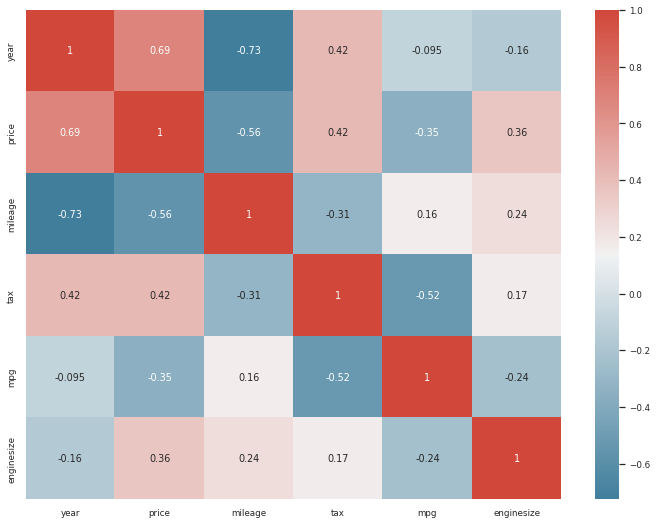

In [21]:
corr = df.corr(method='pearson') 
print(corr.head())


plt.figure(figsize=(12,9)) #seleccionamos un tamaño de imagen mayor
sns.set(font_scale=0.8) #seleccionamos un tamaño de letra legible
# preparación del gráfico definiendo un mapa de colores
cmap = sns.diverging_palette(230, 15, as_cmap=True)
# graficamos la correlación
sns.heatmap(corr, annot=True,  cmap=cmap)
plt.show()

EL SIGUIENTE PASO OBSERVAMOS QUE NO EXISTE UNA CORRELACIÓN ENTRE LAS VARIABLES INCLUSO BAJANDO EL UMBRAL HASTA 0.7


In [22]:
triang_sup = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# Imponemos el umbral seleccionado sobre la matriz de correlación
variablescorr_drop = [column for column in triang_sup.columns if any(triang_sup[column] > 0.7)]#el primer par se encuentra recién cuándo se baja el umbral hasta 0.4, apareciendo price y tax
print(variablescorr_drop) 

[]


###MATRIZ DE DISPERSIÓN

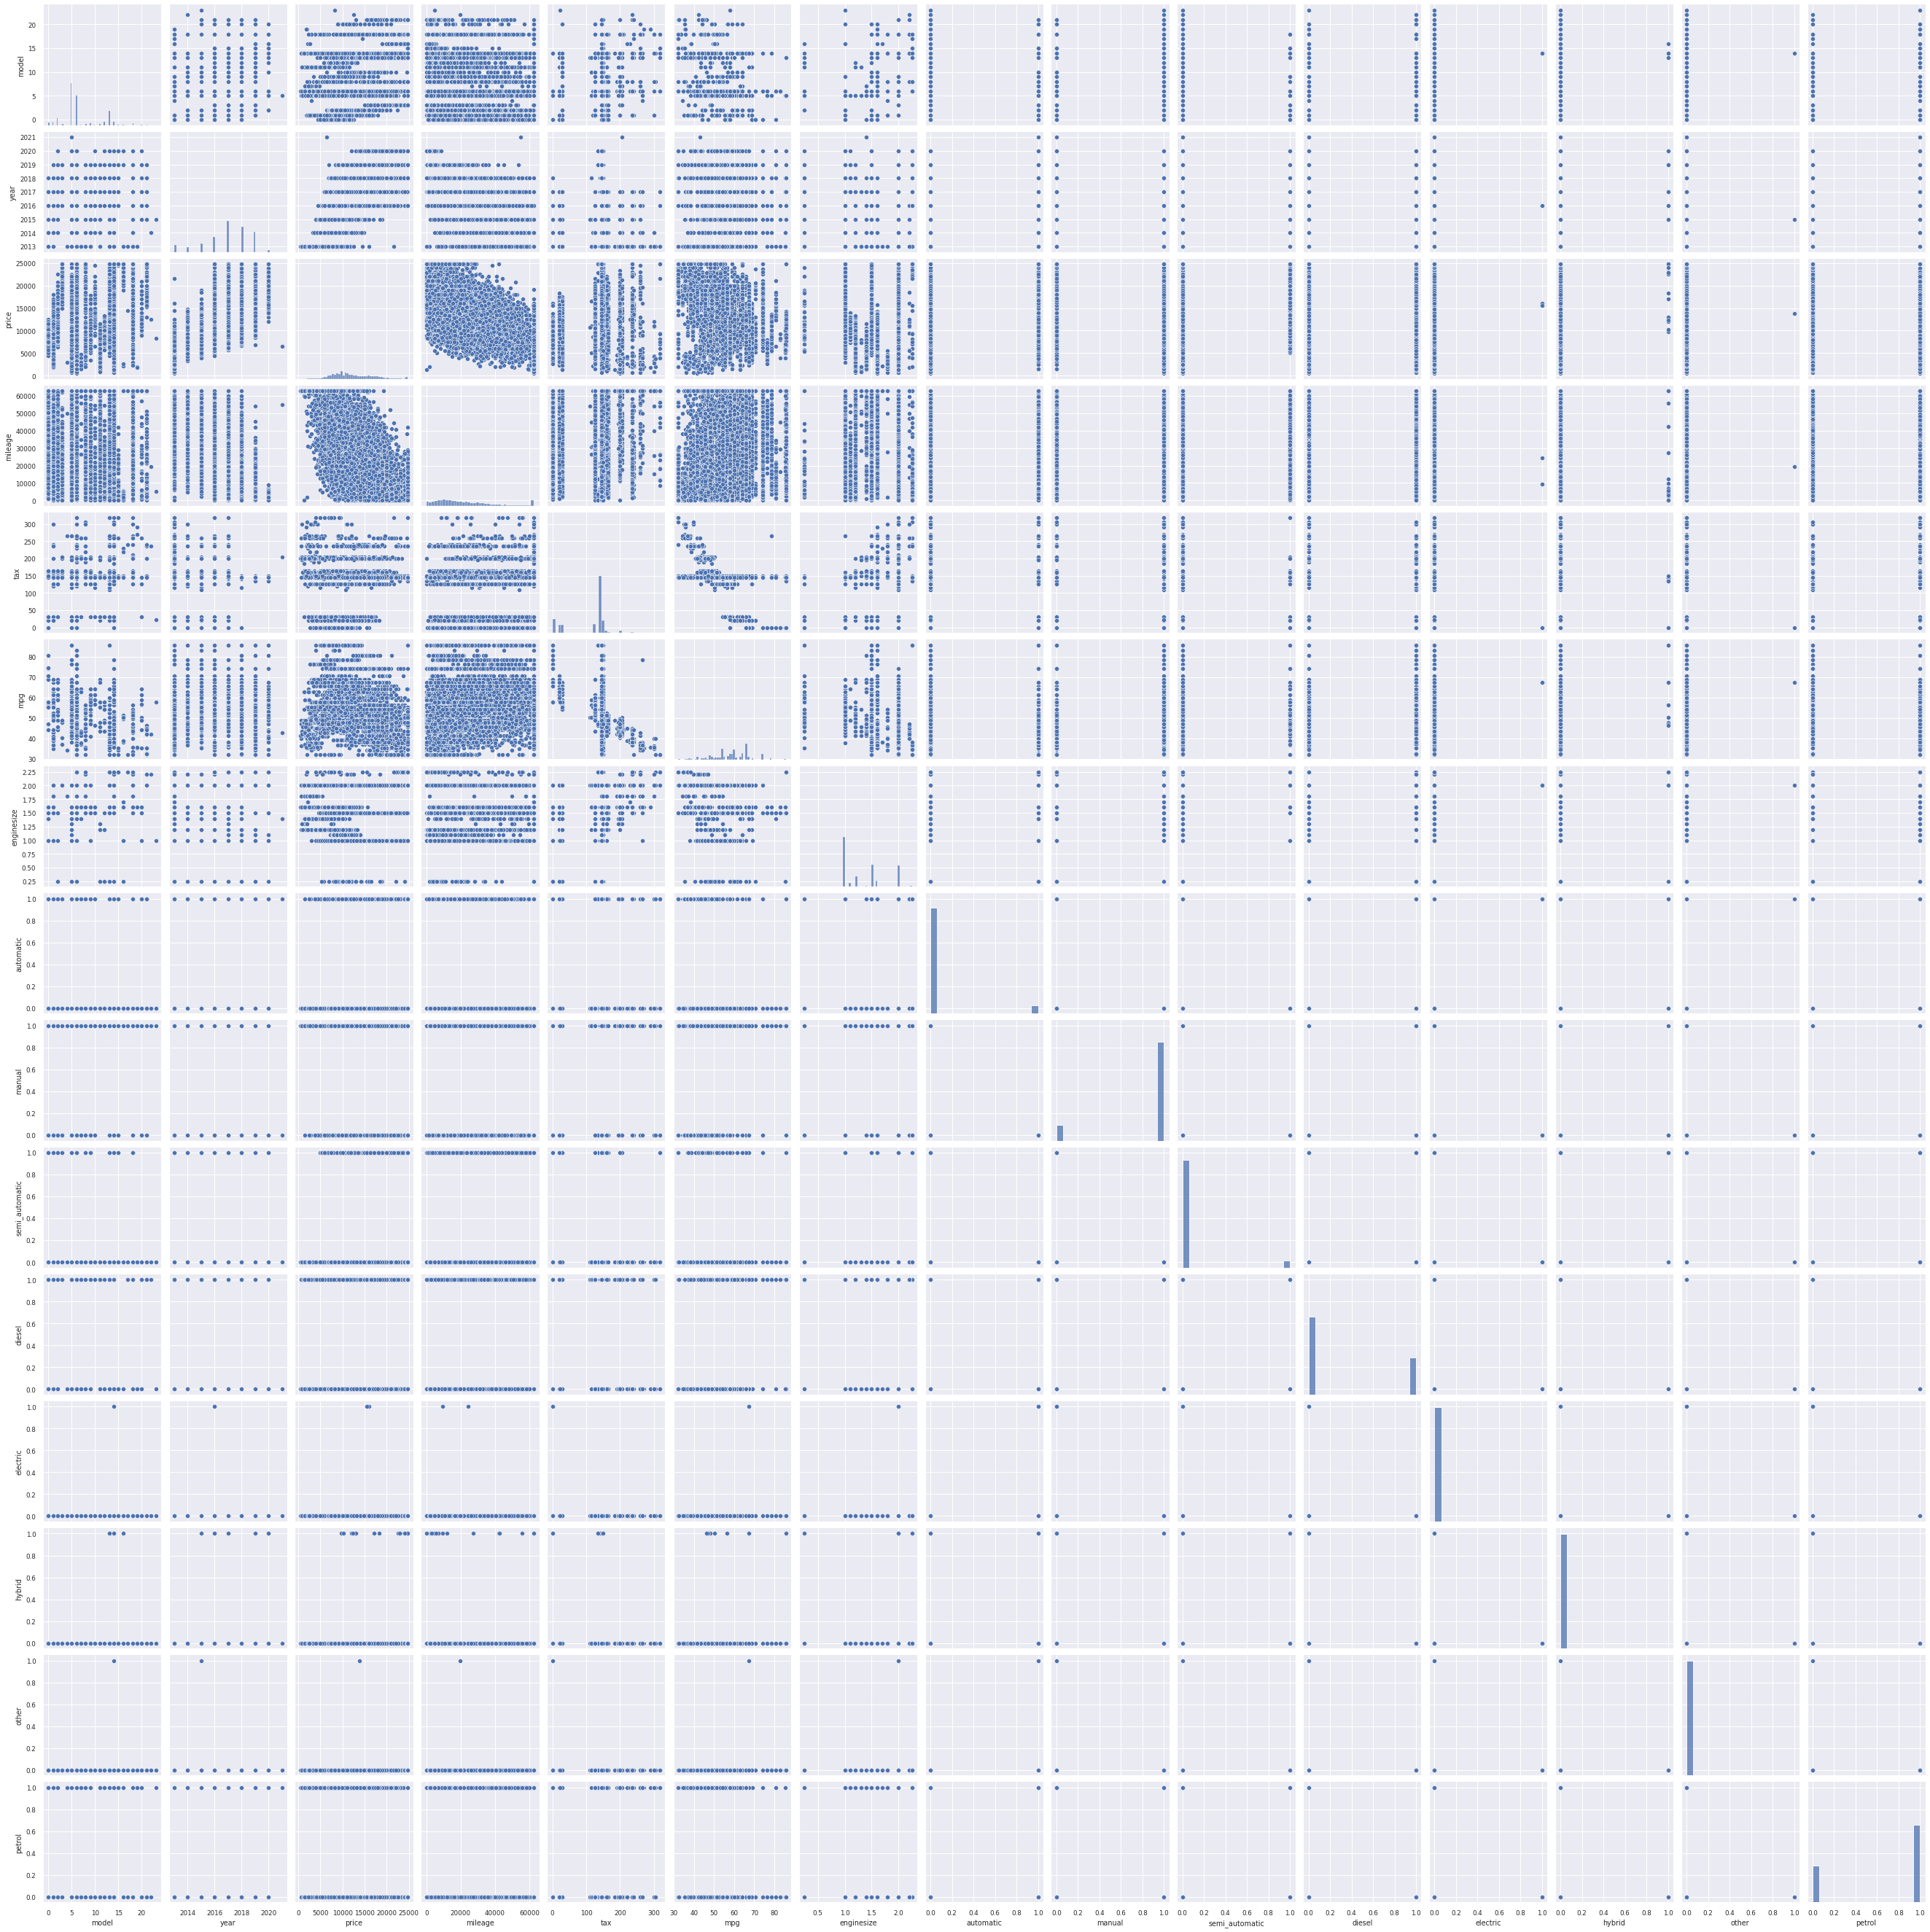

In [23]:
sns.pairplot(df)
plt.show()

###ANÁLISIS DEL COEFICIENTE VIF

TODOS LOS VALORES MENORES A 5 POR LO QUE NO HAY COLINEALIDAD ENTRE ELLAS, ALGO QUE YA NOS LO HACÍA SABER LA MATRIZ DE CORRELACIÓN


In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
dfvif = df.drop('price', axis=1) #eliminamos la columna de la variable respuesta Y.
dfvif.shape[1] #hacemos la comprobación

dfvif = dfvif.drop('model', axis=1)
dfvif = dfvif.drop('automatic', axis=1)
dfvif = dfvif.drop('manual', axis=1)
dfvif = dfvif.drop('semi_automatic', axis=1)

dfvif = dfvif.drop('diesel', axis=1)
dfvif = dfvif.drop('electric', axis=1)
dfvif = dfvif.drop('hybrid', axis=1)
dfvif = dfvif.drop('other', axis=1)
dfvif = dfvif.drop('petrol', axis=1)

'''
dfvif["model"] = pd.to_numeric(dfvif["model"])
dfvif["automatic"] = pd.to_numeric(dfvif["automatic"])
dfvif["manual"] = pd.to_numeric(dfvif["manual"])
dfvif["semi_automatic"] = pd.to_numeric(dfvif["semi_automatic"])
dfvif["diesel"] = pd.to_numeric(dfvif["diesel"])
dfvif["electric"] = pd.to_numeric(dfvif["electric"])
dfvif["hybrid"] = pd.to_numeric(dfvif["hybrid"])
dfvif["other"] = pd.to_numeric(dfvif["other"])
dfvif["petrol"] = pd.to_numeric(dfvif["petrol"])
'''
#print(dfvif.info())

def estandariza(data_features):
    data_features = (data_features - data_features.mean()) /   data_features.std()
    return data_features


dfvif_estan = dfvif.apply(estandariza, axis=0)
print(dfvif_estan.head())


vif_estan = [[dfvif_estan.columns[i], variance_inflation_factor(dfvif_estan.to_numpy(), i)] for i in range(dfvif.shape[1])]
df_vif_estan=pd.DataFrame(vif_estan)  
df_vif_estan=df_vif_estan.rename(columns = {0:'Variable',1:'VIF'})
df_vif_estan                                                                            


       year   mileage       tax       mpg  enginesize
0  0.023915 -0.394438  0.602864 -0.020270   -0.880184
1  0.612494 -0.812106  0.602864 -0.020270   -0.880184
2  0.023915 -0.606772  0.602864 -0.020270   -0.880184
3  1.201072 -0.728280  0.521044 -1.812141    0.398513
4  1.201072 -1.274822  0.521044 -0.947100   -0.880184


,Variable,VIF
0,year,2.431727
1,mileage,2.276736
2,tax,1.733517
3,mpg,1.484296
4,enginesize,1.185163


###INTERPRETACIÓN DE LOS RESULTADOS


CÓMO VIMOS LOS MECANIMOS NO SUPERVISADOS NO PROPUSIERON NINGUNA VARIABLE A DESCARTAR DEBIDO A QUE NO SE  COLINEALIDAD ENTRE ELLAS.

ANALIZAREMOS ENTONCES EN UNA TABLA LAS VARIABLES PROPUESTAS POR LOS MECANISMOS SUPERVISADOS.


In [32]:
cant_variables = 4 

dfKBest_r = dfKBest_r.head(cant_variables)
dfKBest_f = dfKBest_f.head(cant_variables)
dfsfs_b = dfsfs_b.head(cant_variables)
dfsfs_f = dfsfs_f.head(cant_variables)
dfrfe = dfrfe.head(cant_variables)
dfrfecv = dfrfecv.head(cant_variables)


data = {'dfKBest_r': dfKBest_r,
        'dfKBest_f':dfKBest_f,
        'dfsfs_b':dfsfs_b,
        'dfsfs_f':dfsfs_f,
        'dfrfe':dfrfe,
        'dfrfecv':dfrfecv

        }
df = pd.DataFrame(data, columns = ['dfKBest_r', 'dfKBest_f', 'dfsfs_b','dfsfs_f' ,'dfrfe' ,'dfrfecv'])
print(df)



  dfKBest_r dfKBest_f dfsfs_b dfsfs_f           dfrfe  dfrfecv
0     model       NaN     NaN     NaN             NaN      NaN
1      year      year    year    year            year     year
2       NaN     price   price   price           price    price
3   mileage   mileage     NaN     NaN             NaN  mileage
4       NaN       NaN     tax     tax             NaN      tax
5       mpg       mpg     mpg     mpg             mpg      NaN
9       NaN       NaN     NaN     NaN  semi_automatic      NaN


SEGÚN OBSERVAMOS EN LA TABLA ANTERIOR NOS DECIDIMOS POR QUEDAR CON 4 VARIABLES, ESTÁS SERÁN : YEAR , MILEAGE, TAX Y MPG . ESTO DEBIDO A QUÉ SON LOS QUE MÁS REPITEN ENTRE LOS DIFERENTES ALGORITMOS DE SELECCIÓN DE VARIABLES.

##PARTE IV
Evaluar los métodos de regularización para diferentes valores de  λ  y construir una tabla comparativa donde se evalúen la importancia de las variables predictoras y las métricas. Seleccionar el modelo óptimo (LR, Ridge o Lasso) y razonar la elección.

###LASSO EVALUADO CON ALPHA = 0.1

In [33]:
from sklearn.linear_model import Lasso
lasso_regression = Lasso(alpha=0.01, random_state = 8) 
lasso=lasso_regression.fit(X_train, Y_train)
print("Los parámetros de la regresión de Lasso son\n", lasso.coef_) #Comprobamos el peso que se asigna a las distintas variables predictoras
Y_train_pred_lasso = lasso_regression.predict(X_train)
Y_test_pred_lasso = lasso_regression.predict(X_test)
###############Cálculo de las métricas#######################
print("Métricas calculadas sobre la muestra de entrenamiento")
metricasLasso_train=calculametricas(Y_train, Y_train_pred_lasso)
print("Métricas calculadas sobre la muestra de test")
metricasLasso_test_0_1=calculametricas(Y_test, Y_test_pred_lasso)




Los parámetros de la regresión de Lasso son
 [ 0.02877677  0.57591866 -0.22491413 -0.04456518 -0.20459417  0.34257033
  0.00234859 -0.05475233  0.          0.          0.          0.00534436
  0.         -0.1175083 ]
Métricas calculadas sobre la muestra de entrenamiento
Métricas calculadas sobre la muestra de test


###LASSO EVALUADO CON ALPHA = 0.9


In [48]:
from sklearn.linear_model import Lasso
lasso_regression = Lasso(alpha=0.09, random_state = 8) 
lasso=lasso_regression.fit(X_train, Y_train)
print("Los parámetros de la regresión de Lasso son\n", lasso.coef_) #Comprobamos el peso que se asigna a las distintas variables predictoras
Y_train_pred_lasso = lasso_regression.predict(X_train)
Y_test_pred_lasso = lasso_regression.predict(X_test)
###############Cálculo de las métricas#######################
print("Métricas calculadas sobre la muestra de entrenamiento")
metricasLasso_train=calculametricas(Y_train, Y_train_pred_lasso)
print("Métricas calculadas sobre la muestra de test")
metricasLasso_test_0_9=calculametricas(Y_test, Y_test_pred_lasso)

Los parámetros de la regresión de Lasso son
 [ 0.00138925  0.53149379 -0.157605    0.         -0.09233528  0.36650344
  0.         -0.02055266  0.          0.          0.          0.
  0.         -0.        ]
Métricas calculadas sobre la muestra de entrenamiento
Métricas calculadas sobre la muestra de test


###RIDGE EVALUADO CON ALPHA = 1

In [35]:
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=1, solver = 'auto', random_state = 9) #Si selecionamos alpha = 0 se correspondería con una regresión lineal sin penalización
ridge=ridge_regression.fit(X_train, Y_train)

Y_train_pred_ridge = ridge_regression.predict(X_train)
Y_test_pred_ridge = ridge_regression.predict(X_test)
###############Cálculo de las métricas#######################
print("Métricas calculadas sobre la muestra de entrenamiento")
metricasRidge_train=calculametricas(Y_train, Y_train_pred_ridge)
print("Métricas calculadas sobre la muestra de test")
metricasRidge_test_1 =calculametricas(Y_test, Y_test_pred_ridge)










Métricas calculadas sobre la muestra de entrenamiento
Métricas calculadas sobre la muestra de test


###RIDGE EVALUADO CON ALPHA = 10

In [42]:
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=10, solver = 'auto', random_state = 9) #Si selecionamos alpha = 0 se correspondería con una regresión lineal sin penalización
ridge=ridge_regression.fit(X_train, Y_train)

Y_train_pred_ridge = ridge_regression.predict(X_train)
Y_test_pred_ridge = ridge_regression.predict(X_test)
###############Cálculo de las métricas#######################
print("Métricas calculadas sobre la muestra de entrenamiento")
metricasRidge_train=calculametricas(Y_train, Y_train_pred_ridge)
print("Métricas calculadas sobre la muestra de test")
metricasRidge_test_10 =calculametricas(Y_test, Y_test_pred_ridge)










Métricas calculadas sobre la muestra de entrenamiento
Métricas calculadas sobre la muestra de test


In [50]:

dfmetricasLR_test=pd.DataFrame(metricasLR_test)


dfmetricasLasso_test_0_1=pd.DataFrame(metricasLasso_test_0_1)
dfmetricasLasso_test_0_9=pd.DataFrame(metricasLasso_test_0_9)

dfmetricasRidge_test_1=pd.DataFrame(metricasRidge_test_1)
dfmetricasRidge_test_10=pd.DataFrame(metricasRidge_test_10)



dfmetricasLRRL_test=pd.concat([dfmetricasLR_test, dfmetricasLasso_test_0_1, dfmetricasLasso_test_0_9 , dfmetricasRidge_test_1,dfmetricasRidge_test_10  ],axis=1,ignore_index=True)
dfmetricasLRRL_test = dfmetricasLRRL_test.rename(columns = {0:'LR',1:'Lasso 0.1',2:'Lasso 0.9', 3:'Ridge 1' , 4:'Ridge 10'},index={0: 'MAE',1:'MSE',2:'RMSE',3:'R2'})
dfmetricasLRRL_test



,LR,Lasso 0.1,Lasso 0.9,Ridge 1,Ridge 10
MAE,0.366880,0.367075,0.397028,0.366165,0.366259
MSE,0.233660,0.234224,0.268922,0.233424,0.233889
RMSE,0.483384,0.483966,0.518577,0.483140,0.483621
R2,0.760666,0.760089,0.724548,0.760908,0.760432


### CONCLUSIÓN FINAL

VEMOS CÓMO AJUSTANDO EL VALOR DEL ALPHA LIMITAMOS MÁS VALORES Y POR TANTO OBTENEMOS UNA VARIACIÓN LIGERA SOBRE EL INDICADOR DEL R2 ,  MANIOBRAR EL ALPHA PUEDE MEJORAR EL RESULTADO , SIN EMBARGO SI SE SE AJUSTA DEMASIADO LA EFECTIVIDAD DISMINUYE

##PARTE V

Construir los modelos de regresión (sin y con regularización) a partir del dataframe con el número de variables predictoras óptimas. Escribir el modelo resultante de la regresión lineal sin regularización y los modelos obtenidos con las regresiones con regularización de Ridge y Lasso. Comparar los modelos e interpretarlos a partir de las métricas y las técnicas validación gráfica.


###SELECCIÓN DE VARIABLES FINALES

SEGÚN OBSERVAMOS EN PARTE III, SECCIÓN "INTERPRETACIÓN DE LOS RESULTADOS" LAS VARIABLES SELECCIONADAS LUEGO DE ANALIZAR LOS DIFERENTES MECANISMOS DE DESCARTE SON LAS SIGUIENTES: 

*   YEAR
*   MILEAGE
*   TAX
*   MPG

###PREPARACIÓN DE LOS DATOS

In [60]:
 
print(df_original)

df = df_original['year','mileage','tax','mpg']



         model  year  price transmission  mileage fuelType  tax   mpg  \
0       Fiesta  2017  12000    Automatic    15944   Petrol  150  57.7   
1        Focus  2018  14000       Manual     9083   Petrol  150  57.7   
2        Focus  2017  13000       Manual    12456   Petrol  150  57.7   
3       Fiesta  2019  17500       Manual    10460   Petrol  145  40.3   
4       Fiesta  2019  16500    Automatic     1482   Petrol  145  48.7   
...        ...   ...    ...          ...      ...      ...  ...   ...   
17961    B-MAX  2017   8999       Manual    16700   Petrol  150  47.1   
17962    B-MAX  2014   7499       Manual    40700   Petrol   30  57.7   
17963    Focus  2015   9999       Manual     7010   Diesel   20  67.3   
17964       KA  2018   8299       Manual     5007   Petrol  145  57.7   
17965    Focus  2015   8299       Manual     5007   Petrol   22  57.7   

       engineSize  
0             1.0  
1             1.0  
2             1.0  
3             1.5  
4             1.0  
...

KeyError: ignored